install required libraries

In [2]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install optuna
!pip install seaborn
!pip install -U cupy-cuda12x
!pip uninstall -y catboost  # Remove old version (if installed)
!pip install catboost -U  # Install latest version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 18.3 MB/s eta 0:00:00


**Load Data**
from google drive, and create the panda dataframe.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/MLCW1/CW1_train.csv"

import pandas as pd
df = pd.read_csv(file_path)  # Example for CSV files
print(df.head())

Mounted at /content/drive
     outcome  carat        cut color clarity  depth  table  price     x     y  \
0 -26.701232   1.14      Ideal     G     VS1   62.3   56.0   7948  6.73  6.70   
1   6.548093   0.38    Premium     H     VS2   60.5   59.0    898  4.69  4.66   
2   6.612562   0.50  Very Good     E     SI1   60.7   58.0   1351  5.09  5.13   
3  -5.073562   0.70    Premium     D     SI1   61.2   58.0   2512  5.74  5.70   
4 -14.436557   0.83      Ideal     G     SI2   62.4   54.0   2751  6.01  6.08   

   ...        a6        a7        a8        a9       a10        b6        b7  \
0  ...  0.168836 -0.273758  1.107832  1.247795  0.482344  0.489511 -0.321138   
1  ... -0.256549  0.315373 -0.030326 -0.114335 -1.059588 -1.761360 -1.343951   
2  ... -1.193327 -0.657307 -0.591726 -0.446856 -0.765286 -0.816544 -1.397794   
3  ... -1.740788 -1.778860 -0.825070  0.444932  1.173109  0.453606 -0.263440   
4  ... -0.859322  1.409268  0.861992  1.109063 -1.436722 -1.461618  0.081787   

      

# **1- data preprocessing**:
1.1 check for missing or null values in the data

In [4]:
# Check for missing or null values in the dataset
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Combine into a DataFrame for better visualization
missing_df = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
missing_df = missing_df[missing_df["Missing Values"] > 0].sort_values(by="Missing Values", ascending=False)

# Display the missing values
if missing_df.empty:
    print("No missing values found in the dataset.")
else:
    print(missing_df)

No missing values found in the dataset.


1.2 plot outcome and features distribution

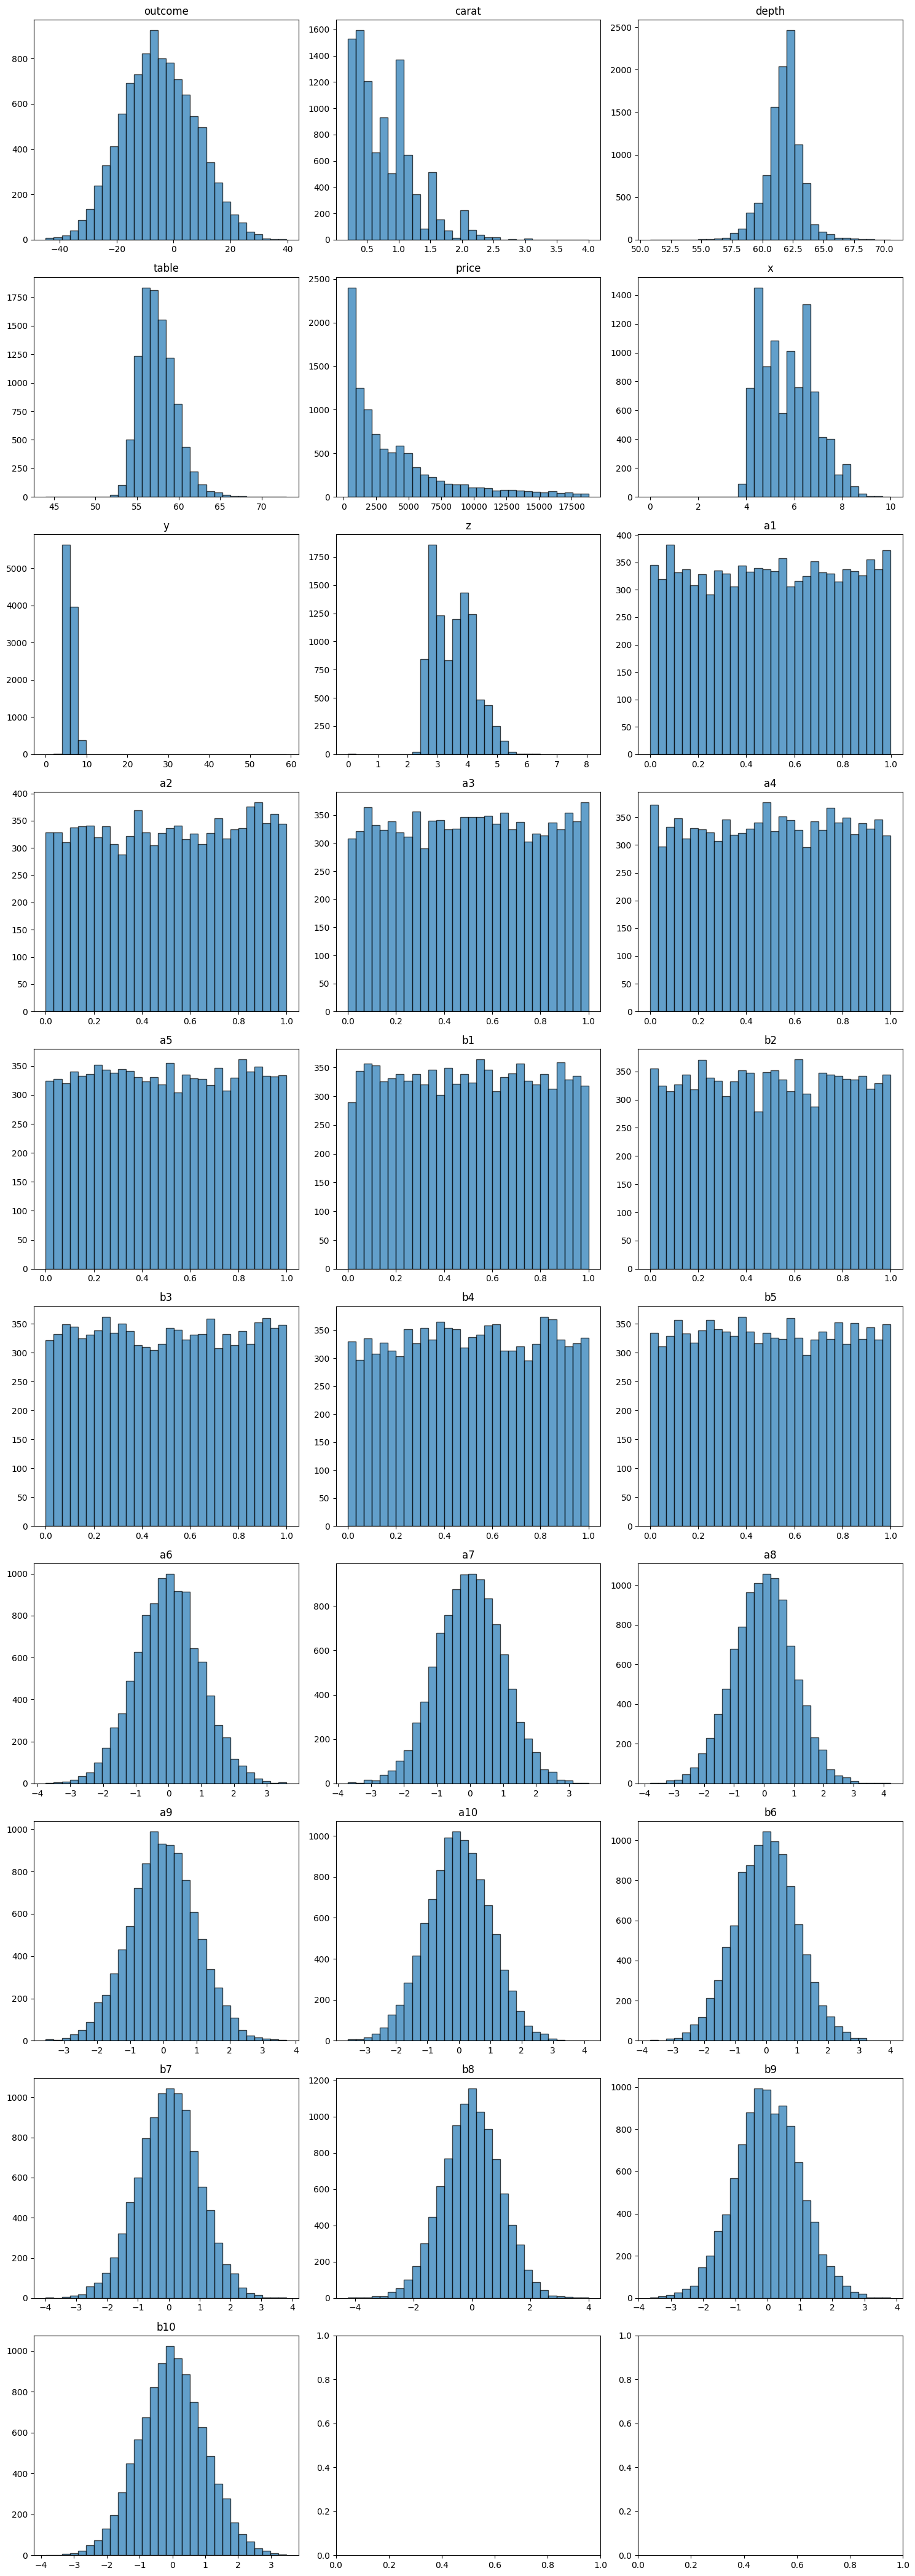

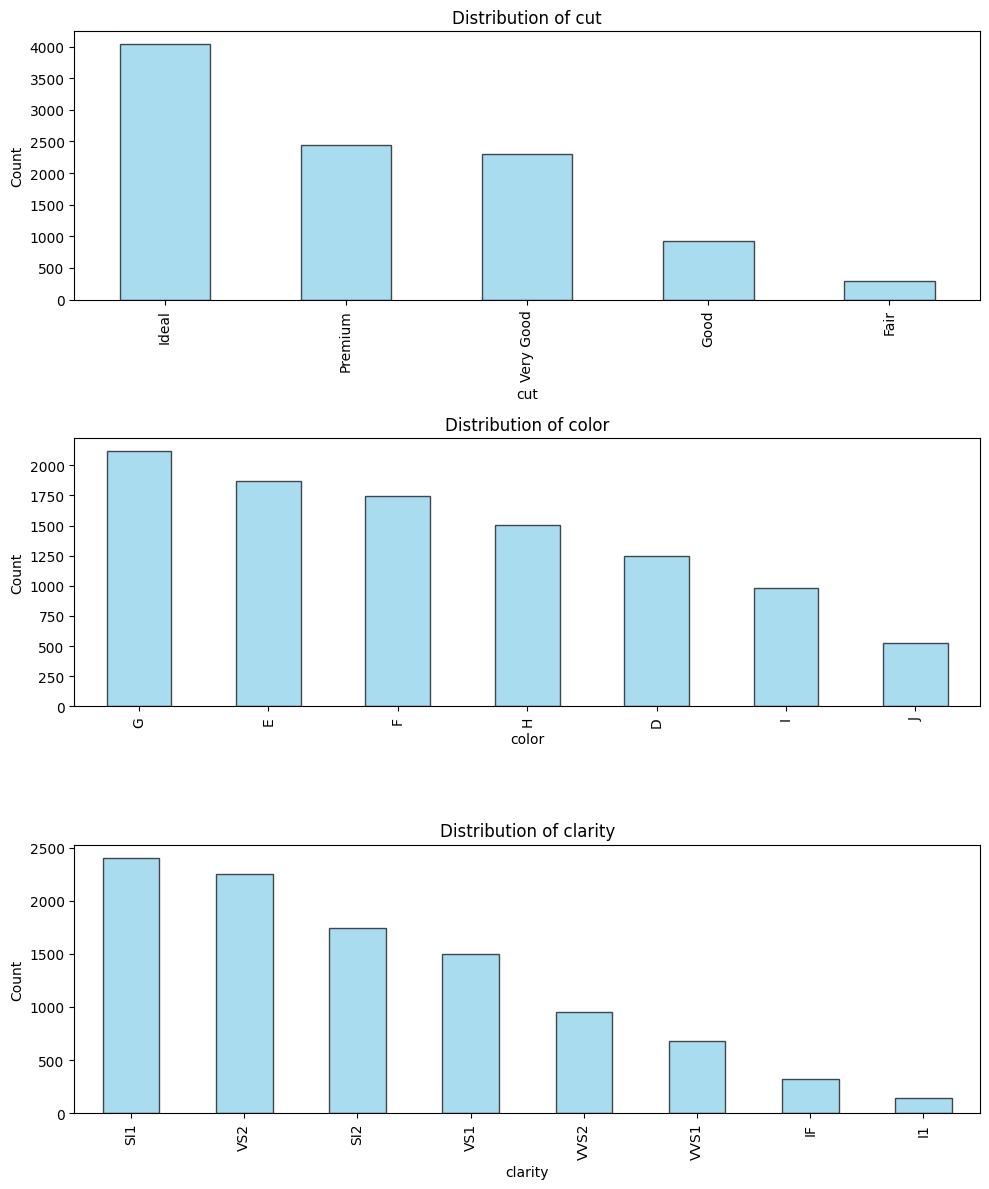

In [4]:
import matplotlib.pyplot as plt

# Separate numerical and categorical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Plot distribution of numerical features
fig, axes = plt.subplots(nrows=len(numerical_columns)//3 + 1, ncols=3, figsize=(15, len(numerical_columns)*1.5))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    axes[i].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

# Plot bar charts for categorical feature distributions
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, len(categorical_columns) * 4))

for i, col in enumerate(categorical_columns):
    df[col].value_counts().plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

1.3 encode catigorical features (color, cut, clarity)

In [5]:
# Define the ordinal encoding for each categorical feature
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"] #Ideal is the best
color_order = ["J", "I", "H", "G", "F", "E", "D"]  # D is the best, J is the worst
clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]  # IF is the best

# Create a mapping dictionary for encoding
cut_mapping = {cut: i for i, cut in enumerate(cut_order)}
color_mapping = {color: i for i, color in enumerate(color_order)}
clarity_mapping = {clarity: i for i, clarity in enumerate(clarity_order)}

# Apply the encoding to the dataframe
df_encoded = df.copy()
df_encoded["cut"] = df_encoded["cut"].map(cut_mapping)
df_encoded["color"] = df_encoded["color"].map(color_mapping)
df_encoded["clarity"] = df_encoded["clarity"].map(clarity_mapping)

1.4 Analyze feature importance:
- calculate corraltion matrix for top 15 features (numerical and catigorcial)
- train a random forest for importance analysis

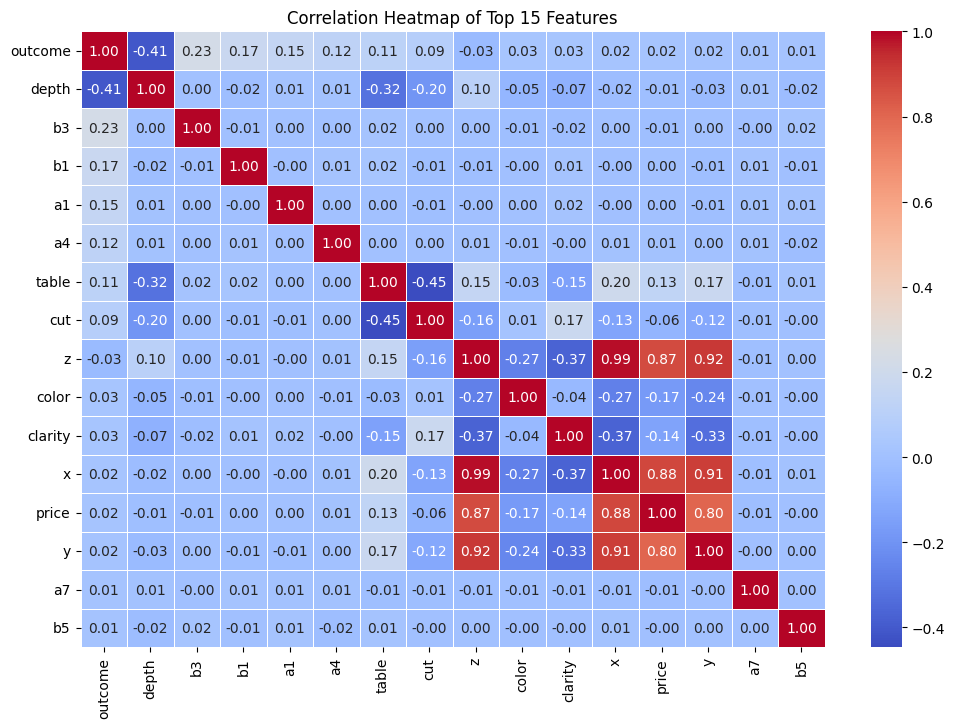

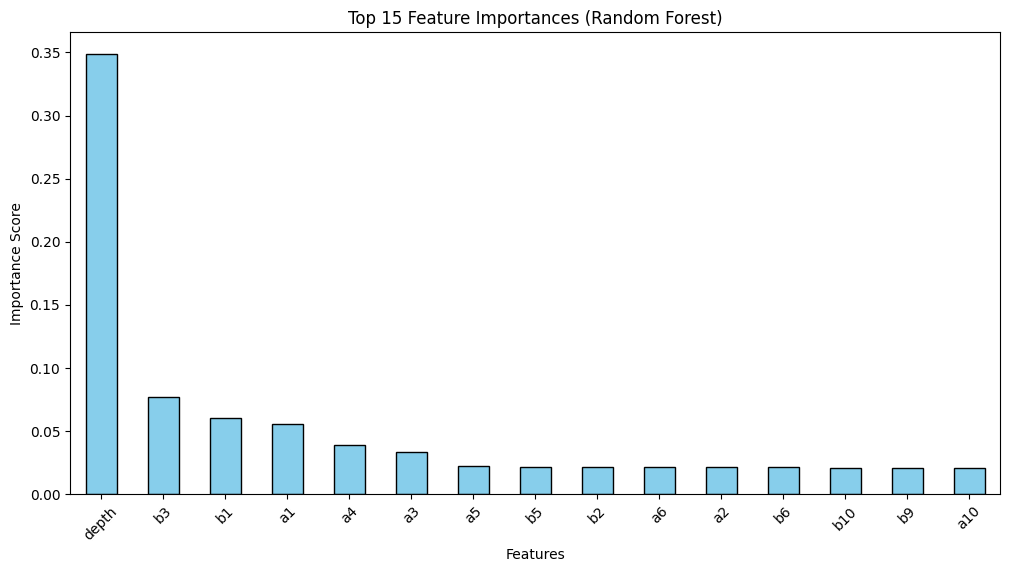

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder

### 2️⃣ Compute Correlation Matrix and Extract Top 15 Features
correlation_matrix = df_encoded.corr()
top_15_features = correlation_matrix["outcome"].drop("outcome").abs().sort_values(ascending=False).head(15).index
top_15_corr_matrix = df_encoded[["outcome"] + list(top_15_features)].corr()

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_15_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Top 15 Features")
plt.show()

### 3️⃣ Random Forest Feature Importance
# Prepare Data
X = df_encoded.drop(columns=["outcome"])
y = df_encoded["outcome"]

# Train a Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Extract Feature Importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
feature_importances.head(15).plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.show()


1.5 feature engineering
- create new features
- transform some featuress
-

In [7]:

import numpy as np
#Feature Engineering:
#log transformations for skewed distributions.
df_encoded["carat_log"] = np.log1p(df_encoded["carat"])
df_encoded["price_log"] = np.log1p(df_encoded["price"])

df_encoded["depth_x_table"] = df_encoded["depth"] * df_encoded["table"]
df_encoded["depth_x_carat"] = df_encoded["depth"] * df_encoded["carat"]

print(df_encoded.info())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   outcome        10000 non-null  float64
 1   carat          10000 non-null  float64
 2   cut            10000 non-null  int64  
 3   color          10000 non-null  int64  
 4   clarity        10000 non-null  int64  
 5   depth          10000 non-null  float64
 6   table          10000 non-null  float64
 7   price          10000 non-null  int64  
 8   x              10000 non-null  float64
 9   y              10000 non-null  float64
 10  z              10000 non-null  float64
 11  a1             10000 non-null  float64
 12  a2             10000 non-null  float64
 13  a3             10000 non-null  float64
 14  a4             10000 non-null  float64
 15  a5             10000 non-null  float64
 16  b1             10000 non-null  float64
 17  b2             10000 non-null  float64
 18  b3     

#2 Model Selection: Comparing models

**1. training the models with fixed selected features and Bayesian optimizer for 30 trials to find best hyperparameters.**

1.1 catboost

In [8]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.metrics import r2_score, mean_squared_error
import optuna



# Select high-importance features
a_b_features = [f"a{i}" for i in range(1, 6)] + [f"b{i}" for i in range(1, 6)]

# Final feature set
selected_features = ["carat", "depth", "table", "x", "y",
                     "depth_x_table", "depth_x_carat", "carat_log", "price_log"] + a_b_features +["cut", "color", "clarity"]

# Create final dataset
X = df_encoded[selected_features]
print(X.head())
y = df["outcome"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Optuna Objective Function for CatBoost
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 5000),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0.1, 2.0),
        "task_type": "GPU",  # Use GPU acceleration
        "loss_function": "RMSE",
        "random_seed": 42,
        "verbose": 0,  # Keep training silent
        "use_best_model": True
    }

    # Train Model
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

    # Predictions
    y_val_pred = model.predict(X_test)

    # Compute Validation R² Score
    val_r2 = r2_score(y_test, y_val_pred)

    return val_r2  # We maximize validation R²

# 🔥 Run Bayesian Optimization with 30 trials
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

# Print Best Parameters
best_params_catboost = study.best_params
print(f"✅ Best CatBoost Parameters: {best_params_catboost}")

# Train Final Model Using Best Parameters
final_catboost_model = CatBoostRegressor(**best_params_catboost)
final_catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# Predictions
y_train_pred = final_catboost_model.predict(X_train)
y_val_pred = final_catboost_model.predict(X_test)

# Compute R² scores
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_test, y_val_pred)

# Compute Mean Squared Error (MSE)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_test, y_val_pred)

# Print Results
print(f"✅ Training R² Score: {train_r2:.5f}")
print(f"✅ Validation R² Score: {val_r2:.5f}")
print(f"✅ Training MSE: {train_mse:.5f}")
print(f"✅ Validation MSE: {val_mse:.5f}")



[I 2025-02-19 16:35:51,717] A new study created in memory with name: no-name-3077812e-469f-47fe-b902-8b330149ea5c


   carat  depth  table     x     y  depth_x_table  depth_x_carat  carat_log  \
0   1.14   62.3   56.0  6.73  6.70         3488.8         71.022   0.760806   
1   0.38   60.5   59.0  4.69  4.66         3569.5         22.990   0.322083   
2   0.50   60.7   58.0  5.09  5.13         3520.6         30.350   0.405465   
3   0.70   61.2   58.0  5.74  5.70         3549.6         42.840   0.530628   
4   0.83   62.4   54.0  6.01  6.08         3369.6         51.792   0.604316   

   price_log        a1  ...        a4        a5        b1        b2        b3  \
0   8.980801  0.709585  ...  0.500222  0.462145  0.806922  0.891912  0.276683   
1   6.801283  0.649532  ...  0.052079  0.008600  0.496153  0.092878  0.089039   
2   7.209340  0.550496  ...  0.131802  0.317685  0.821415  0.581294  0.876056   
3   7.829233  0.982447  ...  0.232601  0.267207  0.800913  0.984788  0.070506   
4   7.920083  0.030877  ...  0.923147  0.861377  0.997349  0.091662  0.781069   

         b4        b5  cut  color  cla

[I 2025-02-19 16:36:00,895] Trial 0 finished with value: 0.4659300514005258 and parameters: {'iterations': 2949, 'depth': 5, 'learning_rate': 0.012665946249536522, 'l2_leaf_reg': 3.6266288785276486, 'border_count': 37, 'random_strength': 0.8694699465218044}. Best is trial 0 with value: 0.4659300514005258.
[I 2025-02-19 16:36:24,315] Trial 1 finished with value: 0.46709865372258763 and parameters: {'iterations': 2383, 'depth': 10, 'learning_rate': 0.035392697611885425, 'l2_leaf_reg': 0.07891329850770575, 'border_count': 219, 'random_strength': 1.8016298817939338}. Best is trial 1 with value: 0.46709865372258763.
[I 2025-02-19 16:37:14,933] Trial 2 finished with value: 0.4639533511750006 and parameters: {'iterations': 4981, 'depth': 10, 'learning_rate': 0.010606803435833034, 'l2_leaf_reg': 0.1018407629841673, 'border_count': 231, 'random_strength': 0.8077656750601903}. Best is trial 1 with value: 0.46709865372258763.
[I 2025-02-19 16:37:21,502] Trial 3 finished with value: 0.465857048892

✅ Best CatBoost Parameters: {'iterations': 2223, 'depth': 4, 'learning_rate': 0.025454615994497113, 'l2_leaf_reg': 1.3076897468913697, 'border_count': 105, 'random_strength': 1.7558485336291243}
0:	learn: 12.5757101	test: 12.6396692	best: 12.6396692 (0)	total: 3.03ms	remaining: 6.73s
100:	learn: 9.4312181	test: 9.6841017	best: 9.6841017 (100)	total: 121ms	remaining: 2.54s
200:	learn: 9.1650570	test: 9.4790030	best: 9.4790030 (200)	total: 239ms	remaining: 2.41s
300:	learn: 9.0537728	test: 9.4140594	best: 9.4140594 (300)	total: 356ms	remaining: 2.27s
400:	learn: 8.9575759	test: 9.3763234	best: 9.3763076 (399)	total: 473ms	remaining: 2.15s
500:	learn: 8.8538195	test: 9.3488894	best: 9.3488894 (500)	total: 591ms	remaining: 2.03s
600:	learn: 8.7546749	test: 9.3331358	best: 9.3307317 (577)	total: 709ms	remaining: 1.91s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 9.330731682
bestIteration = 577

Shrink model to first 578 iterations.
✅ Training R² Score: 0.52332
✅ Validat

1.2 XGBoost

In [10]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Train-Test Split (if not done already)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Optuna Objective Function for XGBoost
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 5000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "random_state": 42,
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "device": "cuda" # Use GPU acceleration
    }

    # Train Model
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Predictions
    y_val_pred = model.predict(X_test)

    # Compute Validation R² Score
    val_r2 = r2_score(y_test, y_val_pred)

    return val_r2  # We maximize validation R²

# 🔥 Run Bayesian Optimization with 30 trials
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)  # n_jobs=1 to prevent GPU conflicts

# Print Best Parameters
best_params_xgboost = study.best_params
print(f"✅ Best XGBoost Parameters: {best_params_xgboost}")

# Train Final Model Using Best Parameters
final_xgboost_model = XGBRegressor(**best_params_xgboost)
final_xgboost_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

# Predictions
y_train_pred = final_xgboost_model.predict(X_train)
y_val_pred = final_xgboost_model.predict(X_test)

# Compute R² scores
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_test, y_val_pred)

# Compute Mean Squared Error (MSE)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_test, y_val_pred)

# Print Results
print(f"✅ Training R² Score: {train_r2:.5f}")
print(f"✅ Validation R² Score: {val_r2:.5f}")
print(f"✅ Training MSE: {train_mse:.5f}")
print(f"✅ Validation MSE: {val_mse:.5f}")


[I 2025-02-19 16:44:43,076] A new study created in memory with name: no-name-b409ad38-eccd-4d18-9038-b37c35449d37
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:52] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2025-02-19 16:44:52,254] Trial 0 finished with value: 0.43523634404031 and parameters: {'n_estimators': 2754, 'max_depth': 7, 'learning_rate': 0.010035787480133566, 'subsample': 0.6335661373318123, 'colsample_bytree': 0.8691399051785911, 'reg_lambda': 3.0482316484642737, 'reg_alpha': 0.016835027425374304, 'gamma': 2.877548267

✅ Best XGBoost Parameters: {'n_estimators': 2285, 'max_depth': 3, 'learning_rate': 0.013470454634649348, 'subsample': 0.9171149952751915, 'colsample_bytree': 0.5011259719011553, 'reg_lambda': 9.602905312116482, 'reg_alpha': 0.44476611660110854, 'gamma': 2.155462654902764}
[0]	validation_0-rmse:12.75795
[100]	validation_0-rmse:10.52219
[200]	validation_0-rmse:9.77243
[300]	validation_0-rmse:9.55629
[400]	validation_0-rmse:9.45955
[500]	validation_0-rmse:9.41799
[600]	validation_0-rmse:9.39671
[700]	validation_0-rmse:9.38134
[800]	validation_0-rmse:9.37461
[900]	validation_0-rmse:9.36756
[1000]	validation_0-rmse:9.36423
[1100]	validation_0-rmse:9.36741
[1200]	validation_0-rmse:9.36769
[1300]	validation_0-rmse:9.36736
[1400]	validation_0-rmse:9.36802
[1500]	validation_0-rmse:9.36869
[1600]	validation_0-rmse:9.36917
[1700]	validation_0-rmse:9.37175
[1800]	validation_0-rmse:9.37478
[1900]	validation_0-rmse:9.37488
[2000]	validation_0-rmse:9.37437
[2100]	validation_0-rmse:9.37524
[2200]	vali

1.3 Neural Networks

In [12]:
import optuna
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Standardize Features (X)
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Define Neural Network Model
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, dropout_rate, activation_func):
        super(MLPModel, self).__init__()
        layers = []

        # Input Layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation_func)
        layers.append(nn.Dropout(dropout_rate))

        # Hidden Layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation_func)
            layers.append(nn.Dropout(dropout_rate))

        # Output Layer
        layers.append(nn.Linear(hidden_dim, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define Optuna Objective Function for Neural Network
def objective(trial):
    # Hyperparameter Search Space
    hidden_dim = trial.suggest_int("hidden_dim", 32, 512)
    hidden_layers = trial.suggest_int("hidden_layers", 1, 5)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 256)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "leaky_relu"])

    # Define Activation Function
    if activation == "relu":
        activation_func = nn.ReLU()
    elif activation == "tanh":
        activation_func = nn.Tanh()
    else:
        activation_func = nn.LeakyReLU()

    # Create Model
    model = MLPModel(input_dim=X_train.shape[1], hidden_dim=hidden_dim, hidden_layers=hidden_layers,
                     dropout_rate=dropout_rate, activation_func=activation_func).to(device)

    # Define Loss & Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare DataLoader
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Train Model
    epochs = 50
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluate Model
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_tensor).cpu().numpy()

    val_r2 = r2_score(y_test, y_val_pred)

    return val_r2  # We maximize validation R²

# 🔥 Run Bayesian Optimization with 30 trials
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30, n_jobs=1)  # n_jobs=1 to prevent GPU conflicts

# Print Best Parameters
best_params_nn = study.best_params
print(f"✅ Best Neural Network Parameters: {best_params_nn}")

# Train Final Model Using Best Parameters
final_model = MLPModel(
    input_dim=X_train.shape[1],
    hidden_dim=best_params_nn["hidden_dim"],
    hidden_layers=best_params_nn["hidden_layers"],
    dropout_rate=best_params_nn["dropout_rate"],
    activation_func=nn.ReLU() if best_params_nn["activation"] == "relu" else
                   nn.Tanh() if best_params_nn["activation"] == "tanh" else nn.LeakyReLU()
).to(device)

# Define Loss & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params_nn["learning_rate"])

# Prepare DataLoader
batch_size = best_params_nn["batch_size"]
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train Final Model
epochs = 100
for epoch in range(epochs):
    final_model.train()
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = final_model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

# Evaluate Final Model
final_model.eval()
with torch.no_grad():
    y_train_pred = final_model(X_train_tensor).cpu().numpy()
    y_val_pred = final_model(X_test_tensor).cpu().numpy()

# Compute R² scores
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_test, y_val_pred)

# Compute Mean Squared Error (MSE)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_test, y_val_pred)

# Print Results
print(f"✅ Training R² Score: {train_r2:.5f}")
print(f"✅ Validation R² Score: {val_r2:.5f}")
print(f"✅ Training MSE: {train_mse:.5f}")
print(f"✅ Validation MSE: {val_mse:.5f}")


[I 2025-02-19 17:07:39,271] A new study created in memory with name: no-name-7e2ec26b-4bbf-485c-9a65-a25eaea0e6f7
[I 2025-02-19 17:07:47,320] Trial 0 finished with value: 0.3011738710168578 and parameters: {'hidden_dim': 380, 'hidden_layers': 5, 'dropout_rate': 0.1468868218113783, 'learning_rate': 0.0014146645400587902, 'batch_size': 198, 'activation': 'relu'}. Best is trial 0 with value: 0.3011738710168578.
[I 2025-02-19 17:08:07,892] Trial 1 finished with value: 0.4409840974176419 and parameters: {'hidden_dim': 291, 'hidden_layers': 3, 'dropout_rate': 0.1119894392295307, 'learning_rate': 0.00011885676151830661, 'batch_size': 42, 'activation': 'tanh'}. Best is trial 1 with value: 0.4409840974176419.
[I 2025-02-19 17:08:18,521] Trial 2 finished with value: 0.39050900557618384 and parameters: {'hidden_dim': 226, 'hidden_layers': 1, 'dropout_rate': 0.32960040170842697, 'learning_rate': 0.005768160996318732, 'batch_size': 67, 'activation': 'leaky_relu'}. Best is trial 1 with value: 0.4409

✅ Best Neural Network Parameters: {'hidden_dim': 120, 'hidden_layers': 3, 'dropout_rate': 0.28381561128288785, 'learning_rate': 0.0008775423156606707, 'batch_size': 49, 'activation': 'tanh'}
✅ Training R² Score: 0.55103
✅ Validation R² Score: 0.44599
✅ Training MSE: 72.52956
✅ Validation MSE: 90.30704


#3 Model training and evaluation


3.1 Training Catboost, and selecting the features using recurusive feature elimination(RFE), and finding best hyperparameters using optuna.

In [11]:
from sklearn.feature_selection import RFECV
from catboost import CatBoostRegressor
import optuna
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split


X = df_encoded.copy().drop(columns=["z", "outcome"]) # z is highly corralted with x (0.99), redundent to keep both.
print(X.head())
y = df_encoded["outcome"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Apply RFE to Find the Best Features
base_model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.05, loss_function="RMSE", verbose=0, task_type="GPU")

selector = RFECV(base_model, step=1, cv=5, scoring="r2")
selector.fit(X_train, y_train)

# Get Selected Features After RFE
selected_features_rfe = X_train.columns[selector.support_]
print(f"✅ Selected Features After RFE: {list(selected_features_rfe)}")

# Train-Test Split with Selected Features
X_train_rfe, X_test_rfe = X_train[selected_features_rfe], X_test[selected_features_rfe]

# Step 2: Run Bayesian Optimization Again for RFE-Selected Features
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 5000),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0.1, 2.0),
        "task_type": "GPU",
        "loss_function": "RMSE",
        "random_seed": 42,
        "verbose": 0,
        "use_best_model": True
    }

    # Train Model with RFE-Selected Features
    model = CatBoostRegressor(**params)
    model.fit(X_train_rfe, y_train, eval_set=(X_test_rfe, y_test), early_stopping_rounds=50, verbose=0)

    # Evaluate
    y_val_pred = model.predict(X_test_rfe)
    val_r2 = r2_score(y_test, y_val_pred)

    return val_r2  # Maximize validation R²

# Run Optuna Bayesian Optimization on RFE-Selected Features
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

# Print Best Parameters After RFE
best_params_rfe = study.best_params
print(f"✅ Best CatBoost Parameters After RFE: {best_params_rfe}")

# Step 3: Train Final CatBoost Model with RFE-Selected Features & Optimized Hyperparameters
final_model_rfe = CatBoostRegressor(**best_params_rfe)
final_model_rfe.fit(X_train_rfe, y_train, eval_set=(X_test_rfe, y_test), early_stopping_rounds=50, verbose=100)

# Compute Final R² and MSE Scores
y_train_pred_rfe = final_model_rfe.predict(X_train_rfe)
y_test_pred_rfe = final_model_rfe.predict(X_test_rfe)

train_r2_rfe = r2_score(y_train, y_train_pred_rfe)
val_r2_rfe = r2_score(y_test, y_test_pred_rfe)
train_mse_rfe = mean_squared_error(y_train, y_train_pred_rfe)
val_mse_rfe = mean_squared_error(y_test, y_test_pred_rfe)

# Print Results
print(f"✅ Training R² Score After RFE: {train_r2_rfe:.5f}")
print(f"✅ Validation R² Score After RFE: {val_r2_rfe:.5f}")
print(f"✅ Training MSE After RFE: {train_mse_rfe:.5f}")
print(f"✅ Validation MSE After RFE: {val_mse_rfe:.5f}")


   carat  cut  color  clarity  depth  table  price     x     y        a1  ...  \
0   1.14    4      3        4   62.3   56.0   7948  6.73  6.70  0.709585  ...   
1   0.38    3      2        3   60.5   59.0    898  4.69  4.66  0.649532  ...   
2   0.50    2      5        2   60.7   58.0   1351  5.09  5.13  0.550496  ...   
3   0.70    3      6        2   61.2   58.0   2512  5.74  5.70  0.982447  ...   
4   0.83    4      3        1   62.4   54.0   2751  6.01  6.08  0.030877  ...   

        a10        b6        b7        b8        b9       b10  carat_log  \
0  0.482344  0.489511 -0.321138  0.573382  0.446871 -1.990581   0.760806   
1 -1.059588 -1.761360 -1.343951 -1.002550 -0.225030 -0.446653   0.322083   
2 -0.765286 -0.816544 -1.397794 -0.477130  0.810509  1.725131   0.405465   
3  1.173109  0.453606 -0.263440  0.246210 -0.850503 -0.412950   0.530628   
4 -1.436722 -1.461618  0.081787  0.258087  0.851146  2.204813   0.604316   

   price_log  depth_x_table  depth_x_carat  
0   8.98080

[I 2025-02-19 20:02:26,123] A new study created in memory with name: no-name-218ffd21-090a-43c0-8fc6-5f556e10fd76


✅ Selected Features After RFE: ['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'depth_x_carat']


[I 2025-02-19 20:02:29,324] Trial 0 finished with value: 0.4652788682641201 and parameters: {'iterations': 2905, 'depth': 3, 'learning_rate': 0.0761740235836035, 'l2_leaf_reg': 0.2715397151453934, 'border_count': 194, 'random_strength': 0.6468267409746337}. Best is trial 0 with value: 0.4652788682641201.
[I 2025-02-19 20:02:35,014] Trial 1 finished with value: 0.4615862306196018 and parameters: {'iterations': 2264, 'depth': 9, 'learning_rate': 0.06147143882537564, 'l2_leaf_reg': 0.08751930789492782, 'border_count': 213, 'random_strength': 1.7048115504552155}. Best is trial 0 with value: 0.4652788682641201.
[I 2025-02-19 20:02:43,168] Trial 2 finished with value: 0.460222545278973 and parameters: {'iterations': 2027, 'depth': 8, 'learning_rate': 0.0279033681249422, 'l2_leaf_reg': 2.084920577337929, 'border_count': 189, 'random_strength': 0.5409695306211668}. Best is trial 0 with value: 0.4652788682641201.
[I 2025-02-19 20:02:47,577] Trial 3 finished with value: 0.46357504829989604 and p

✅ Best CatBoost Parameters After RFE: {'iterations': 2055, 'depth': 3, 'learning_rate': 0.0973238410685613, 'l2_leaf_reg': 0.0552961498984783, 'border_count': 213, 'random_strength': 0.4072343262703507}
0:	learn: 12.2218755	test: 12.3064413	best: 12.3064413 (0)	total: 1.9ms	remaining: 3.9s
100:	learn: 8.9794954	test: 9.3620523	best: 9.3620523 (100)	total: 98.2ms	remaining: 1.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 9.34975303
bestIteration = 130

Shrink model to first 131 iterations.
✅ Training R² Score After RFE: 0.50777
✅ Validation R² Score After RFE: 0.46371
✅ Training MSE After RFE: 79.51668
✅ Validation MSE After RFE: 87.41788


3.2. Train CatBoost with selected Features & Best RFE Hyperparameters

In [12]:
# Load the best hyperparameters found from RFE optimization
best_params_rfe = {
    "iterations": 2055,
    "depth": 3,
    "learning_rate": 0.0973238410685613,
    "l2_leaf_reg": 0.0552961498984783,
    "border_count": 213,
    "random_strength": 0.4072343262703507,
    "task_type": "GPU",  # Use GPU for acceleration
    "loss_function": "RMSE",
    "random_seed": 42,
    "verbose": 100,
    "use_best_model": True
}

# Select high-importance features
a_b_features = [f"a{i}" for i in range(1, 6)] + [f"b{i}" for i in range(1, 6)]

# Final feature set
selected_features = ["carat", "depth", "table", "x", "y",
                     "depth_x_table", "depth_x_carat", "carat_log", "price_log"] + a_b_features +["cut", "color", "clarity"]

# Create final dataset
X = df_encoded[selected_features]
print(X.head())
y = df_encoded["outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train CatBoost using **all original features** instead of RFE-selected ones
X_train_all, X_test_all = X_train, X_test  # Use all selected features

# Train Final Model Using All selected Features with Best Hyperparameters from RFE
final_model_all_features = CatBoostRegressor(**best_params_rfe)
final_model_all_features.fit(X_train_all, y_train, eval_set=(X_test_all, y_test), early_stopping_rounds=50, verbose=100)

# Compute R² Scores & MSE
y_train_pred_all = final_model_all_features.predict(X_train_all)
y_test_pred_all = final_model_all_features.predict(X_test_all)

train_r2_all = r2_score(y_train, y_train_pred_all)
val_r2_all = r2_score(y_test, y_test_pred_all)
train_mse_all = mean_squared_error(y_train, y_train_pred_all)
val_mse_all = mean_squared_error(y_test, y_test_pred_all)

# Print Results
print(f"✅ Training R² Score with All Features: {train_r2_all:.5f}")
print(f"✅ Validation R² Score with All Features: {val_r2_all:.5f}")
print(f"✅ Training MSE with All Features: {train_mse_all:.5f}")
print(f"✅ Validation MSE with All Features: {val_mse_all:.5f}")


   carat  depth  table     x     y  depth_x_table  depth_x_carat  carat_log  \
0   1.14   62.3   56.0  6.73  6.70         3488.8         71.022   0.760806   
1   0.38   60.5   59.0  4.69  4.66         3569.5         22.990   0.322083   
2   0.50   60.7   58.0  5.09  5.13         3520.6         30.350   0.405465   
3   0.70   61.2   58.0  5.74  5.70         3549.6         42.840   0.530628   
4   0.83   62.4   54.0  6.01  6.08         3369.6         51.792   0.604316   

   price_log        a1  ...        a4        a5        b1        b2        b3  \
0   8.980801  0.709585  ...  0.500222  0.462145  0.806922  0.891912  0.276683   
1   6.801283  0.649532  ...  0.052079  0.008600  0.496153  0.092878  0.089039   
2   7.209340  0.550496  ...  0.131802  0.317685  0.821415  0.581294  0.876056   
3   7.829233  0.982447  ...  0.232601  0.267207  0.800913  0.984788  0.070506   
4   7.920083  0.030877  ...  0.923147  0.861377  0.997349  0.091662  0.781069   

         b4        b5  cut  color  cla

3.3 train catboost with all selected features, best hyperparameters from RFE, and binning "carat".

In [21]:
from sklearn.preprocessing import KBinsDiscretizer

# Create final dataset
X = df_encoded[selected_features]
print(X.head())
y = df_encoded["outcome"]

# Define the binning strategy
n_bins = 2
binning_strategy = "quantile"

# Apply binning to 'carat'
binning_carat = KBinsDiscretizer(n_bins=n_bins, encode="onehot-dense", strategy=binning_strategy)
carat_binned = binning_carat.fit_transform(X[["carat"]])  # Must be 2D array

# Convert to DataFrame
carat_binned_df = pd.DataFrame(carat_binned, columns=[f"carat_bin_{i}" for i in range(carat_binned.shape[1])])

# Combine with X (replace original 'carat' feature)
X_binned = X.drop(columns=["carat"])  # Drop original 'carat'
X_binned = pd.concat([X_binned, carat_binned_df], axis=1)

print(f"✅ Binned 'carat' into {n_bins} categories and replaced it in X.")

# Train-Test Split with Binned Features
X_train_binned, X_test_binned, y_train, y_test = train_test_split(X_binned, y, test_size=0.2, random_state=42)

# Train CatBoost Again with Binned `carat`
catboost_model_binned = CatBoostRegressor(**best_params_rfe)
catboost_model_binned.fit(X_train_binned, y_train, eval_set=(X_test_binned, y_test), early_stopping_rounds=50, verbose=100)

# Compute R² Scores & MSE
y_train_pred_binned = catboost_model_binned.predict(X_train_binned)
y_test_pred_binned = catboost_model_binned.predict(X_test_binned)

train_r2_binned = r2_score(y_train, y_train_pred_binned)
val_r2_binned = r2_score(y_test, y_test_pred_binned)
train_mse_binned = mean_squared_error(y_train, y_train_pred_binned)
val_mse_binned = mean_squared_error(y_test, y_test_pred_binned)

# Print Results
print(f"✅ Training R² Score with Binned Carat: {train_r2_binned:.5f}")
print(f"✅ Validation R² Score with Binned Carat: {val_r2_binned:.5f}")
print(f"✅ Training MSE with Binned Carat: {train_mse_binned:.5f}")
print(f"✅ Validation MSE with Binned Carat: {val_mse_binned:.5f}")



   carat  depth  table     x     y  depth_x_table  depth_x_carat  carat_log  \
0   1.14   62.3   56.0  6.73  6.70         3488.8         71.022   0.760806   
1   0.38   60.5   59.0  4.69  4.66         3569.5         22.990   0.322083   
2   0.50   60.7   58.0  5.09  5.13         3520.6         30.350   0.405465   
3   0.70   61.2   58.0  5.74  5.70         3549.6         42.840   0.530628   
4   0.83   62.4   54.0  6.01  6.08         3369.6         51.792   0.604316   

   price_log        a1  ...        a4        a5        b1        b2        b3  \
0   8.980801  0.709585  ...  0.500222  0.462145  0.806922  0.891912  0.276683   
1   6.801283  0.649532  ...  0.052079  0.008600  0.496153  0.092878  0.089039   
2   7.209340  0.550496  ...  0.131802  0.317685  0.821415  0.581294  0.876056   
3   7.829233  0.982447  ...  0.232601  0.267207  0.800913  0.984788  0.070506   
4   7.920083  0.030877  ...  0.923147  0.861377  0.997349  0.091662  0.781069   

         b4        b5  cut  color  cla

3.4. Train CatBoost Using K-Fold Cross-Validation

In [25]:
from sklearn.model_selection import KFold
import numpy as np

# Create final dataset
X = df_encoded[selected_features]
print(X.head())
y = df_encoded["outcome"]

# Define 17-Fold Cross-Validation
kf = KFold(n_splits=17, shuffle=True, random_state=42)

# Store R² and MSE scores for each fold
r2_scores = []
mse_scores = []

# Use the best hyperparameters found earlier
best_params = {
    "iterations": 2055,
    "depth": 3,
    "learning_rate": 0.0973238410685613,
    "l2_leaf_reg": 0.0552961498984783,
    "border_count": 213,
    "random_strength": 0.4072343262703507,
    "task_type": "GPU",
    "loss_function": "RMSE",
    "random_seed": 42,
    "verbose": 0,
    "use_best_model": True
}

# Perform K-Fold Cross-Validation
for train_idx, val_idx in kf.split(X):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    # Train CatBoost Model
    model = CatBoostRegressor(**best_params)
    model.fit(X_train_cv, y_train_cv, eval_set=(X_val_cv, y_val_cv), early_stopping_rounds=50, verbose=200)

    # Evaluate Model
    y_pred_cv = model.predict(X_val_cv)
    r2_cv = r2_score(y_val_cv, y_pred_cv)
    mse_cv = mean_squared_error(y_val_cv, y_pred_cv)

    r2_scores.append(r2_cv)
    mse_scores.append(mse_cv)

# Compute Average Scores Across All Folds
final_cv_r2 = np.mean(r2_scores)
final_cv_mse = np.mean(mse_scores)

# Print Results
print(f"✅ Cross-Validated R² Score (17-Fold): {final_cv_r2:.5f}")
print(f"✅ Cross-Validated MSE (17-Fold): {final_cv_mse:.5f}")


   depth  table     x     y  depth_x_table  depth_x_carat  carat_log  \
0   62.3   56.0  6.73  6.70         3488.8         71.022   0.760806   
1   60.5   59.0  4.69  4.66         3569.5         22.990   0.322083   
2   60.7   58.0  5.09  5.13         3520.6         30.350   0.405465   
3   61.2   58.0  5.74  5.70         3549.6         42.840   0.530628   
4   62.4   54.0  6.01  6.08         3369.6         51.792   0.604316   

   price_log        a1        a2        a3        a4        a5        b1  \
0   8.980801  0.709585  0.385796  0.267058  0.500222  0.462145  0.806922   
1   6.801283  0.649532  0.037578  0.618528  0.052079  0.008600  0.496153   
2   7.209340  0.550496  0.029469  0.350697  0.131802  0.317685  0.821415   
3   7.829233  0.982447  0.487176  0.339991  0.232601  0.267207  0.800913   
4   7.920083  0.030877  0.818540  0.955872  0.923147  0.861377  0.997349   

         b2        b3        b4        b5  cut  color  
0  0.891912  0.276683  0.967510  0.131087    4      3 

3.5. Running More Optuna Trials to Improve R² on catboost with selected features (100 trials).

In [30]:
import optuna
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Keep `a1-a5, b1-b5` since they ranked high in feature importance
a_b_features = [f"a{i}" for i in range(1, 6)] + [f"b{i}" for i in range(1, 6)]

# Define final feature set
selected_features = ["carat_log", "depth", "table", "x", "y",
                     "depth_x_table", "depth_x_carat", "price_log"] + a_b_features + ["cut", "color", "clarity"]

# Create final dataset
X = df_encoded[selected_features]
print(X.head())
y = df_encoded["outcome"]

print([selected_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Optuna Objective Function
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 5000),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0.1, 2.0),
        "task_type": "GPU",  # Use GPU acceleration
        "loss_function": "RMSE",
        "random_seed": 42,
        "use_best_model": True
    }

    # Train Model
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

    # Evaluate Model
    y_pred = model.predict(X_test)
    val_r2 = r2_score(y_test, y_pred)

    return val_r2  # Maximize Validation R²

# 🔥 Run Bayesian Optimization with 100+ Trials
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

# Print Best Parameters After Optimization
best_params_optimized = study.best_params
print(f"✅ Best CatBoost Parameters After 100 Trials: {best_params_optimized}")

# Train Final Model with Best Parameters
final_model_optimized = CatBoostRegressor(**best_params_optimized)
final_model_optimized.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# Compute Final R² and MSE
y_train_pred = final_model_optimized.predict(X_train)
y_test_pred = final_model_optimized.predict(X_test)

train_r2_optimized = r2_score(y_train, y_train_pred)
val_r2_optimized = r2_score(y_test, y_test_pred)
train_mse_optimized = mean_squared_error(y_train, y_train_pred)
val_mse_optimized = mean_squared_error(y_test, y_test_pred)

# Print Final Results
print(f"✅ Training R² Score After Optimization: {train_r2_optimized:.5f}")
print(f"✅ Validation R² Score After Optimization: {val_r2_optimized:.5f}")
print(f"✅ Training MSE After Optimization: {train_mse_optimized:.5f}")
print(f"✅ Validation MSE After Optimization: {val_mse_optimized:.5f}")


[I 2025-02-19 21:05:35,512] A new study created in memory with name: no-name-b7fef2f0-ccd6-48b3-b841-92a38135c21c


   carat_log  depth  table     x     y  depth_x_table  depth_x_carat  \
0   0.760806   62.3   56.0  6.73  6.70         3488.8         71.022   
1   0.322083   60.5   59.0  4.69  4.66         3569.5         22.990   
2   0.405465   60.7   58.0  5.09  5.13         3520.6         30.350   
3   0.530628   61.2   58.0  5.74  5.70         3549.6         42.840   
4   0.604316   62.4   54.0  6.01  6.08         3369.6         51.792   

   price_log        a1        a2  ...        a4        a5        b1        b2  \
0   8.980801  0.709585  0.385796  ...  0.500222  0.462145  0.806922  0.891912   
1   6.801283  0.649532  0.037578  ...  0.052079  0.008600  0.496153  0.092878   
2   7.209340  0.550496  0.029469  ...  0.131802  0.317685  0.821415  0.581294   
3   7.829233  0.982447  0.487176  ...  0.232601  0.267207  0.800913  0.984788   
4   7.920083  0.030877  0.818540  ...  0.923147  0.861377  0.997349  0.091662   

         b3        b4        b5  cut  color  clarity  
0  0.276683  0.967510  0.

[I 2025-02-19 21:05:53,307] Trial 0 finished with value: 0.4640815263025827 and parameters: {'iterations': 3580, 'depth': 8, 'learning_rate': 0.0077833010148678225, 'l2_leaf_reg': 0.025608128871243713, 'border_count': 60, 'random_strength': 0.4712740377215997}. Best is trial 0 with value: 0.4640815263025827.
[I 2025-02-19 21:06:55,339] Trial 1 finished with value: 0.4639700583594405 and parameters: {'iterations': 4884, 'depth': 9, 'learning_rate': 0.0031858738911341783, 'l2_leaf_reg': 3.4154059193666386, 'border_count': 97, 'random_strength': 1.1355111607309316}. Best is trial 0 with value: 0.4640815263025827.
[I 2025-02-19 21:07:02,671] Trial 2 finished with value: 0.4646513024307314 and parameters: {'iterations': 2035, 'depth': 5, 'learning_rate': 0.016008236407501243, 'l2_leaf_reg': 2.488328473542557, 'border_count': 184, 'random_strength': 1.5560207114335323}. Best is trial 2 with value: 0.4646513024307314.
[I 2025-02-19 21:07:52,145] Trial 3 finished with value: 0.4612722544309832

✅ Best CatBoost Parameters After 100 Trials: {'iterations': 1297, 'depth': 3, 'learning_rate': 0.07531216779615514, 'l2_leaf_reg': 0.019530781732589125, 'border_count': 242, 'random_strength': 1.2206451051589766}
0:	learn: 12.3300354	test: 12.4017776	best: 12.4017776 (0)	total: 1.97ms	remaining: 2.55s
100:	learn: 9.1108674	test: 9.4190773	best: 9.4190773 (100)	total: 114ms	remaining: 1.35s
200:	learn: 8.8874890	test: 9.3431818	best: 9.3431102 (199)	total: 226ms	remaining: 1.23s
300:	learn: 8.7134093	test: 9.3369497	best: 9.3352357 (295)	total: 337ms	remaining: 1.12s
400:	learn: 8.5678478	test: 9.3340020	best: 9.3314858 (357)	total: 449ms	remaining: 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 9.331485841
bestIteration = 357

Shrink model to first 358 iterations.
✅ Training R² Score After Optimization: 0.53910
✅ Validation R² Score After Optimization: 0.46580
✅ Training MSE After Optimization: 74.45598
✅ Validation MSE After Optimization: 87.07663


3.6. Run 300 Optuna Trials on Selected Features

In [31]:
import optuna
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Keep `a1-a5, b1-b5` since they ranked high in feature importance
a_b_features = [f"a{i}" for i in range(1, 6)] + [f"b{i}" for i in range(1, 6)]

# Define final feature set
selected_features = ["carat_log", "depth", "table", "x", "y",
                     "depth_x_table", "depth_x_carat", "price_log"] + a_b_features + ["cut", "color", "clarity"]

# Create final dataset
X = df_encoded[selected_features]
print(X.head())
y = df_encoded["outcome"]

print([selected_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Optuna Objective Function
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 5000),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0.1, 2.0),
        "task_type": "GPU",  # Use GPU acceleration
        "loss_function": "RMSE",
        "random_seed": 42,
        "use_best_model": True
    }

    # Train Model
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0)

    # Evaluate Model
    y_pred = model.predict(X_test)
    val_r2 = r2_score(y_test, y_pred)

    return val_r2  # Maximize Validation R²

# 🔥 Run Bayesian Optimization with 100+ Trials
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=300)

# Print Best Parameters After Optimization
best_params_optimized = study.best_params
print(f"✅ Best CatBoost Parameters After 300 Trials: {best_params_optimized}")

# Train Final Model with Best Parameters
final_model_optimized = CatBoostRegressor(**best_params_optimized)
final_model_optimized.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=100)

# Compute Final R² and MSE
y_train_pred = final_model_optimized.predict(X_train)
y_test_pred = final_model_optimized.predict(X_test)

train_r2_optimized = r2_score(y_train, y_train_pred)
val_r2_optimized = r2_score(y_test, y_test_pred)
train_mse_optimized = mean_squared_error(y_train, y_train_pred)
val_mse_optimized = mean_squared_error(y_test, y_test_pred)

# Print Final Results
print(f"✅ Training R² Score After Optimization: {train_r2_optimized:.5f}")
print(f"✅ Validation R² Score After Optimization: {val_r2_optimized:.5f}")
print(f"✅ Training MSE After Optimization: {train_mse_optimized:.5f}")
print(f"✅ Validation MSE After Optimization: {val_mse_optimized:.5f}")

[I 2025-02-19 21:20:29,536] A new study created in memory with name: no-name-79fe0d24-ff31-4af3-8780-c12166c2264c


   carat_log  depth  table     x     y  depth_x_table  depth_x_carat  \
0   0.760806   62.3   56.0  6.73  6.70         3488.8         71.022   
1   0.322083   60.5   59.0  4.69  4.66         3569.5         22.990   
2   0.405465   60.7   58.0  5.09  5.13         3520.6         30.350   
3   0.530628   61.2   58.0  5.74  5.70         3549.6         42.840   
4   0.604316   62.4   54.0  6.01  6.08         3369.6         51.792   

   price_log        a1        a2  ...        a4        a5        b1        b2  \
0   8.980801  0.709585  0.385796  ...  0.500222  0.462145  0.806922  0.891912   
1   6.801283  0.649532  0.037578  ...  0.052079  0.008600  0.496153  0.092878   
2   7.209340  0.550496  0.029469  ...  0.131802  0.317685  0.821415  0.581294   
3   7.829233  0.982447  0.487176  ...  0.232601  0.267207  0.800913  0.984788   
4   7.920083  0.030877  0.818540  ...  0.923147  0.861377  0.997349  0.091662   

         b3        b4        b5  cut  color  clarity  
0  0.276683  0.967510  0.

[I 2025-02-19 21:20:33,287] Trial 0 finished with value: 0.4642627502957053 and parameters: {'iterations': 2443, 'depth': 7, 'learning_rate': 0.06548997483229776, 'l2_leaf_reg': 0.05067421058150566, 'border_count': 201, 'random_strength': 1.5524433171116354}. Best is trial 0 with value: 0.4642627502957053.
[I 2025-02-19 21:20:43,716] Trial 1 finished with value: 0.4651913339564797 and parameters: {'iterations': 4325, 'depth': 9, 'learning_rate': 0.08624504844500648, 'l2_leaf_reg': 6.933331716214688, 'border_count': 240, 'random_strength': 1.397448163300604}. Best is trial 1 with value: 0.4651913339564797.
[I 2025-02-19 21:20:46,778] Trial 2 finished with value: 0.4672348141690271 and parameters: {'iterations': 4984, 'depth': 4, 'learning_rate': 0.09158492120137052, 'l2_leaf_reg': 8.384553224306519, 'border_count': 149, 'random_strength': 0.2858037446665104}. Best is trial 2 with value: 0.4672348141690271.
[I 2025-02-19 21:20:51,855] Trial 3 finished with value: 0.46765880262360804 and 

✅ Best CatBoost Parameters After 300 Trials: {'iterations': 2566, 'depth': 3, 'learning_rate': 0.07063662134333969, 'l2_leaf_reg': 0.27119666567231326, 'border_count': 223, 'random_strength': 0.8159085985724617}
0:	learn: 12.3526660	test: 12.4249923	best: 12.4249923 (0)	total: 1.58ms	remaining: 4.06s
100:	learn: 9.0918885	test: 9.4083872	best: 9.4083872 (100)	total: 112ms	remaining: 2.73s
200:	learn: 8.8843320	test: 9.3257979	best: 9.3257979 (200)	total: 223ms	remaining: 2.62s
300:	learn: 8.7283405	test: 9.3125466	best: 9.3118076 (298)	total: 332ms	remaining: 2.5s
400:	learn: 8.5941408	test: 9.3212084	best: 9.3097292 (330)	total: 444ms	remaining: 2.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 9.309729228
bestIteration = 330

Shrink model to first 331 iterations.
✅ Training R² Score After Optimization: 0.53317
✅ Validation R² Score After Optimization: 0.46829
✅ Training MSE After Optimization: 75.41423
✅ Validation MSE After Optimization: 86.67106


3.7.  Train CatBoost with 16-Fold Cross-Validation and best hyperparameters from previous best trial ( trial number 293).

In [35]:
from sklearn.model_selection import KFold
import numpy as np


# Keep `a1-a5, b1-b5` since they ranked high in feature importance
a_b_features = [f"a{i}" for i in range(1, 6)] + [f"b{i}" for i in range(1, 6)]

# Define final feature set
selected_features = ["carat_log", "depth", "table", "x", "y",
                     "depth_x_table", "depth_x_carat", "price_log"] + a_b_features + ["cut", "color", "clarity"]

# Create final dataset
X = df_encoded[selected_features]
print(X.head())
y = df_encoded["outcome"]

# Define 17-Fold Cross-Validation
kf = KFold(n_splits=16, shuffle=True, random_state=42)

# Store R² and MSE scores for each fold
r2_scores = []
mse_scores = []

# Use the best hyperparameters from Optuna (Trial 293)
best_params = {
    "iterations": 2566,
    "depth": 3,
    "learning_rate": 0.07063662134333969,
    "l2_leaf_reg": 0.27119666567231326,
    "border_count": 223,
    "random_strength": 0.8159085985724617,
    "task_type": "GPU",
    "loss_function": "RMSE",
    "random_seed": 42,
    "verbose": 0,
    "use_best_model": True
}

# Perform K-Fold Cross-Validation
for train_idx, val_idx in kf.split(X):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    # Train CatBoost Model
    model = CatBoostRegressor(**best_params)
    model.fit(X_train_cv, y_train_cv, eval_set=(X_val_cv, y_val_cv), early_stopping_rounds=50, verbose=0)

    # Evaluate Model
    y_pred_cv = model.predict(X_val_cv)
    r2_cv = r2_score(y_val_cv, y_pred_cv)
    mse_cv = mean_squared_error(y_val_cv, y_pred_cv)

    r2_scores.append(r2_cv)
    mse_scores.append(mse_cv)

# Compute Final Cross-Validated Scores
final_cv_r2 = np.mean(r2_scores)
final_cv_mse = np.mean(mse_scores)

# Print Results
print(f"✅ Cross-Validated R² Score (16-Fold): {final_cv_r2:.5f}")
print(f"✅ Cross-Validated MSE (16-Fold): {final_cv_mse:.5f}")


   carat_log  depth  table     x     y  depth_x_table  depth_x_carat  \
0   0.760806   62.3   56.0  6.73  6.70         3488.8         71.022   
1   0.322083   60.5   59.0  4.69  4.66         3569.5         22.990   
2   0.405465   60.7   58.0  5.09  5.13         3520.6         30.350   
3   0.530628   61.2   58.0  5.74  5.70         3549.6         42.840   
4   0.604316   62.4   54.0  6.01  6.08         3369.6         51.792   

   price_log        a1        a2  ...        a4        a5        b1        b2  \
0   8.980801  0.709585  0.385796  ...  0.500222  0.462145  0.806922  0.891912   
1   6.801283  0.649532  0.037578  ...  0.052079  0.008600  0.496153  0.092878   
2   7.209340  0.550496  0.029469  ...  0.131802  0.317685  0.821415  0.581294   
3   7.829233  0.982447  0.487176  ...  0.232601  0.267207  0.800913  0.984788   
4   7.920083  0.030877  0.818540  ...  0.923147  0.861377  0.997349  0.091662   

         b3        b4        b5  cut  color  clarity  
0  0.276683  0.967510  0.

3.8. Training catboost with best previous parameters
- compare R² score before and after removing outliers from carat.

In [42]:
import pandas as pd

#catboost best params from previous trials.
best_catboost_params = {
    "iterations": 2566,
    "depth": 3,
    "learning_rate": 0.07063662134333969,
    "l2_leaf_reg": 0.27119666567231326,
    "border_count": 223,
    "random_strength": 0.8159085985724617,
    "task_type": "GPU",
    "loss_function": "RMSE",
    "random_seed": 42,
    "use_best_model": False
}

# Keep `a1-a5, b1-b5` (since they rank high in the random forest analysis and correlation matrix)
a_b_features = [f"a{i}" for i in range(1, 6)] + [f"b{i}" for i in range(1, 6)]

# Final feature set: numerical + interactions + binned price + binned carat + `a1-b5` + encoded categorical
selected_features = ["carat", "depth", "table", "x", "y",
                     "depth_x_table", "depth_x_carat", "carat_log", "price_log"] + a_b_features + ["cut", "color", "clarity"]

X = df_encoded[selected_features]
y = df["outcome"]

# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = X[["carat"]].quantile(0.25)
Q3 = X[["carat"]].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove Outliers
X_filtered = X[~((X[["carat"]] < lower_bound) | (X[["carat"]] > upper_bound)).any(axis=1)]
y_filtered = y.loc[X_filtered.index]

print(f"✅ Original Size: {X.shape[0]}, After Outlier Removal: {X_filtered.shape[0]}")

# Train-Test Split (Before & After Outlier Removal)
from sklearn.model_selection import train_test_split

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Train CatBoost Model (Full Data)
model_full = CatBoostRegressor(**best_catboost_params, verbose=100)
model_full.fit(X_train_full, y_train_full)

# Train CatBoost Model (Filtered Data)
model_filtered = CatBoostRegressor(**best_catboost_params, verbose=100)
model_filtered.fit(X_train_filtered, y_train_filtered)

# Evaluate Both Models
from sklearn.metrics import r2_score

y_pred_full = model_full.predict(X_test_full)
y_pred_filtered = model_filtered.predict(X_test_filtered)

r2_full = r2_score(y_test_full, y_pred_full)
r2_filtered = r2_score(y_test_filtered, y_pred_filtered)

print(f"✅ R² with All Data: {r2_full:.5f}")
print(f"✅ R² After Outlier Removal: {r2_filtered:.5f}")



✅ Original Size: 10000, After Outlier Removal: 9667
0:	learn: 12.3495509	total: 6.02ms	remaining: 15.4s
100:	learn: 9.0815679	total: 531ms	remaining: 13s
200:	learn: 8.9579225	total: 1.04s	remaining: 12.3s
300:	learn: 8.8699290	total: 1.55s	remaining: 11.7s
400:	learn: 8.7948840	total: 2.03s	remaining: 11s
500:	learn: 8.7324726	total: 2.5s	remaining: 10.3s
600:	learn: 8.6778895	total: 2.98s	remaining: 9.75s
700:	learn: 8.6248619	total: 3.47s	remaining: 9.23s
800:	learn: 8.5822910	total: 3.94s	remaining: 8.69s
900:	learn: 8.5429988	total: 4.42s	remaining: 8.16s
1000:	learn: 8.5078507	total: 4.89s	remaining: 7.65s
1100:	learn: 8.4688100	total: 5.37s	remaining: 7.14s
1200:	learn: 8.4396261	total: 5.84s	remaining: 6.64s
1300:	learn: 8.4103294	total: 6.31s	remaining: 6.13s
1400:	learn: 8.3835861	total: 6.78s	remaining: 5.63s
1500:	learn: 8.3510123	total: 7.25s	remaining: 5.14s
1600:	learn: 8.3295103	total: 7.73s	remaining: 4.66s
1700:	learn: 8.3087261	total: 8.21s	remaining: 4.17s
1800:	lea

3.9. Implementing ensamble method: Stacking(CatBoost + XGBoost + Neural Networks)

In [38]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Keep `a1-a5, b1-b5` since they ranked high in feature importance
a_b_features = [f"a{i}" for i in range(1, 6)] + [f"b{i}" for i in range(1, 6)]

# Define final feature set
selected_features = ["carat_log", "depth", "table", "x", "y",
                     "depth_x_table", "depth_x_carat", "price_log"] + a_b_features + ["cut", "color", "clarity"]

# Create final dataset
X = df_encoded[selected_features]
y = df_encoded["outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize Features for MLP Only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#catboost best params from previous trials.
best_catboost_params = {
    "iterations": 2566,
    "depth": 3,
    "learning_rate": 0.07063662134333969,
    "l2_leaf_reg": 0.27119666567231326,
    "border_count": 223,
    "random_strength": 0.8159085985724617,
    "task_type": "GPU",
    "loss_function": "RMSE",
    "random_seed": 42,
    "verbose": 0,
    "use_best_model": False
}

best_xgboost_params = {
    "n_estimators": 2285,
    "max_depth": 3,
    "learning_rate": 0.013470454634649348,
    "subsample": 0.9171149952751915,
    "colsample_bytree": 0.5011259719011553,
    "reg_lambda": 9.602905312116482,
    "reg_alpha": 0.44476611660110854,
    "gamma": 2.155462654902764,
    "random_state": 42,
    "device": "cuda",
    "tree_method": "hist"
}

best_mlp_params = {
    "hidden_layer_sizes": (120,) * 3,  # 3 Hidden Layers with 120 Neurons Each
    "activation": "tanh",
    "solver": "adam",
    "learning_rate_init": 0.0008775423156606707,
    "batch_size": 49,
    "alpha": 0.0001,  # Regularization term (default for MLPRegressor)
    "max_iter": 500,
    "random_state": 42
}

# Define Base Models
catboost_model = CatBoostRegressor(**best_catboost_params)
xgboost_model = XGBRegressor(**best_xgboost_params)

# Define MLP Pipeline with Standardization
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Ensure proper normalization
    ("mlp", MLPRegressor(**best_mlp_params))
])

# Define Stacking Model (Meta-Learner: Ridge Regression)
stacked_model = StackingRegressor(
    estimators=[("CatBoost", catboost_model), ("XGBoost", xgboost_model), ("MLP", mlp_pipeline)],
    final_estimator=Ridge(alpha=1.0),
    cv=5  # 5-Fold Cross-Validation inside stacking
)

# Train Stacking Model
stacked_model.fit(X_train_scaled, y_train)

# Evaluate Model
y_pred_stack = stacked_model.predict(X_test_scaled)
stack_r2 = r2_score(y_test, y_pred_stack)
stack_mse = mean_squared_error(y_test, y_pred_stack)

# Print Results
print(f"✅ Stacking Ensemble R² Score: {stack_r2:.5f}")
print(f"✅ Stacking Ensemble MSE: {stack_mse:.5f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:27:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


✅ Stacking Ensemble R² Score: 0.46184
✅ Stacking Ensemble MSE: 87.72250


3.10. trained catboost using:
- one hot encoding for color, clarity, cut
- binning for the price and carat (5 bins)
- selected features
- cross validation using 5 folds.
- run 50 trials with optuna

In [ ]:
import pandas as pd
import numpy as np
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.metrics import r2_score

# Feature Engineering: Keep previous useful transformations
df["carat_log"] = np.log1p(df["carat"])
df["price_log"] = np.log1p(df["price"])
df["depth_x_table"] = df["depth"] * df["table"]
df["depth_x_carat"] = df["depth"] * df["carat"]

# Binning `price` into 4 equal-frequency bins
binning_price = KBinsDiscretizer(n_bins=5, encode="onehot-dense", strategy="quantile")
price_binned = binning_price.fit_transform(df[["price"]])
price_binned_df = pd.DataFrame(price_binned, columns=[f"price_bin_{i}" for i in range(price_binned.shape[1])])

# Binning `carat` into 4 equal-frequency bins
binning_carat = KBinsDiscretizer(n_bins=5, encode="onehot-dense", strategy="quantile")
carat_binned = binning_carat.fit_transform(df[["carat"]])
carat_binned_df = pd.DataFrame(carat_binned, columns=[f"carat_bin_{i}" for i in range(carat_binned.shape[1])])

# Keep `a1-a5, b1-b5` (since they improved R² before)
a_b_features = [f"a{i}" for i in range(1, 6)] + [f"b{i}" for i in range(1, 6)]

# One-Hot Encoding for Categorical Features
categorical_features = ["cut", "color", "clarity"]
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_categorical = encoder.fit_transform(df[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
df_encoded_categorical = pd.DataFrame(encoded_categorical, columns=encoded_feature_names)

# Final feature set: numerical + interactions + binned price + binned carat + `a1-b5` + encoded categorical
selected_features = ["carat", "depth", "table", "x", "y",
                     "depth_x_table", "depth_x_carat", "carat_log", "price_log"] + a_b_features

X = pd.concat([df[selected_features], price_binned_df, carat_binned_df, df_encoded_categorical], axis=1)
y = df["outcome"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Cross-Validation for More Robust Optuna Optimization
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define Optuna Objective Function with Cross-Validation
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 5000),
        "depth": trial.suggest_int("depth", 2, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0.1, 2),
        "task_type": "GPU",  # Ensures GPU acceleration
        "loss_function": "RMSE",
        "verbose": 0  # Disable excessive logging
    }

    r2_scores = []
    for train_idx, test_idx in cv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

        model = CatBoostRegressor(**params)
        model.fit(X_train_cv, y_train_cv, eval_set=(X_test_cv, y_test_cv), early_stopping_rounds=300, verbose=0)

        y_pred_cv = model.predict(X_test_cv)
        r2_scores.append(r2_score(y_test_cv, y_pred_cv))

    return np.mean(r2_scores)

# Run Bayesian Optimization with Optuna
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50, timeout=3600)  # Run 50 trials or stop after 1 hour

# Print Best Parameters
print("🔥 Best Parameters Found:", study.best_params)

# Train Final Model with Best Hyperparameters
best_params = study.best_params
final_model = CatBoostRegressor(**best_params)

# Train with Adaptive Early Stopping (Longer Patience)
final_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=300, verbose=100)

# Predictions & Evaluation
y_pred = final_model.predict(X_test)
final_r2 = r2_score(y_test, y_pred)

# Display Final Results
print(f"✅ Optimized CatBoost R² Score: {final_r2:.4f}")

# Show Feature Importance from CatBoost
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": final_model.get_feature_importance()
}).sort_values(by="Importance", ascending=False)

print("\n📌 Top 10 Most Important Features:")
print(feature_importance.head(10))


[I 2025-02-17 23:14:17,504] A new study created in memory with name: no-name-a6e87866-c096-4fed-8cf4-1d08afd9fcf4
[I 2025-02-17 23:16:20,041] Trial 0 finished with value: 0.47486356389694356 and parameters: {'iterations': 651, 'depth': 10, 'learning_rate': 0.009330474172039143, 'l2_leaf_reg': 0.001244072968035352, 'border_count': 255, 'random_strength': 0.669095396560953}. Best is trial 0 with value: 0.47486356389694356.
[I 2025-02-17 23:18:11,261] Trial 1 finished with value: 0.48029940236043833 and parameters: {'iterations': 3575, 'depth': 5, 'learning_rate': 0.006641779301578866, 'l2_leaf_reg': 0.010238203745151138, 'border_count': 91, 'random_strength': 1.9804579562404412}. Best is trial 1 with value: 0.48029940236043833.
[I 2025-02-17 23:18:50,825] Trial 2 finished with value: 0.4752327987987348 and parameters: {'iterations': 1241, 'depth': 4, 'learning_rate': 0.0059279482528284255, 'l2_leaf_reg': 5.40442498574777, 'border_count': 53, 'random_strength': 0.2522588417024981}. Best i

🔥 Best Parameters Found: {'iterations': 4284, 'depth': 3, 'learning_rate': 0.017181970020733888, 'l2_leaf_reg': 1.1871493461339557, 'border_count': 173, 'random_strength': 1.5232946917610097}
0:	learn: 12.6351360	test: 12.6943507	best: 12.6943507 (0)	total: 1.23ms	remaining: 5.27s
100:	learn: 9.7458941	test: 9.9549799	best: 9.9549799 (100)	total: 115ms	remaining: 4.75s
200:	learn: 9.3742176	test: 9.6307895	best: 9.6307895 (200)	total: 230ms	remaining: 4.68s
300:	learn: 9.2313080	test: 9.5078238	best: 9.5078238 (300)	total: 341ms	remaining: 4.51s
400:	learn: 9.1548170	test: 9.4511718	best: 9.4511718 (400)	total: 453ms	remaining: 4.38s
500:	learn: 9.0946988	test: 9.4092424	best: 9.4092319 (499)	total: 563ms	remaining: 4.25s
600:	learn: 9.0407948	test: 9.3777461	best: 9.3777461 (600)	total: 676ms	remaining: 4.14s
700:	learn: 8.9896598	test: 9.3564486	best: 9.3563122 (691)	total: 791ms	remaining: 4.04s
800:	learn: 8.9403707	test: 9.3400185	best: 9.3400185 (800)	total: 905ms	remaining: 3.93

3.11. trained catboost using:
- best parameters that were found from trial 18 (previous code)
- cross validation using 16 folds
- selected features.

In [ ]:
import pandas as pd
import numpy as np
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Keep `a1-a5, b1-b5` (since they rank high in the random forest analysis and correlation matrix)
a_b_features = [f"a{i}" for i in range(1, 6)] + [f"b{i}" for i in range(1, 6)]

# Final feature set: numerical + interactions + binned price + binned carat + `a1-b5` + encoded categorical
selected_features = ["carat", "depth", "table", "x", "y",
                     "depth_x_table", "depth_x_carat", "carat_log", "price_log"] + a_b_features + ["cut", "color", "clarity"]

X = df_encoded[selected_features]
y = df_encoded["outcome"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Cross-Validation for More Robust Optuna Optimization
cv = KFold(n_splits=16, shuffle=True, random_state=42)

trial_18_params = {
    "iterations": 4284,
    "depth": 2,
    "learning_rate": 0.017181970020733888,
    "l2_leaf_reg": 1.23,
    "border_count": 173,
    "random_strength": 1.5232946917610097,
    "task_type": "GPU",  # Use GPU acceleration
    "loss_function": "RMSE",
    "random_seed": 42,  # Fix randomness
    "verbose": 100,
    "use_best_model": True  # Use best iteration from training
}

# Use Cross-Validation (Same as Optuna)
cv = KFold(n_splits=17, shuffle=True, random_state=42)
r2_scores = []

for train_idx, test_idx in cv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # Train Model
    model = CatBoostRegressor(**trial_18_params)
    model.fit(X_train_cv, y_train_cv, eval_set=(X_test_cv, y_test_cv), verbose=0)

    # Evaluate
    y_pred_cv = model.predict(X_test_cv)
    r2_scores.append(r2_score(y_test_cv, y_pred_cv))

# Compute Final Cross-Validation R² and Best R²
final_cv_r2 = np.mean(r2_scores)
best_cv_r2 = np.max(r2_scores)

# Print results
print(f" Cross-Validated Model R² Score (Mean): {final_cv_r2:.5f}")
print(f" Best R² Score Found in Cross-Validation: {best_cv_r2:.5f}")

 Cross-Validated Model R² Score (Mean): 0.48049
 Best R² Score Found in Cross-Validation: 0.52885
